<font size="5">這是一筆有關工業燈泡壞掉數量相關的資料，主要的預測目標為total_count，我使用的方法為SARMA，是一項關時時間序列分析的統計模型。並使用滑動窗口交叉驗證法進行模型的評估。

In [36]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sktime.forecasting.model_selection import SlidingWindowSplitter
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [40]:
data = pd.read_csv('/kaggle/input/imbd-competition-data/output_new.csv')

<font size="5">資料的統計敘述

In [41]:
data.describe()

,time_index,layer_id,accumulation_hour,count,special_count,water_volume_lower,water_volume_upper,in_temp,out_temp,a_temp,b_temp,total_count
count,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000,1318.000000
mean,22.925645,9.211684,7054.594841,2.471168,0.111533,10.802731,10.815630,20.701214,24.414871,23.178756,24.006525,2.582701
std,11.667135,5.414058,1475.555661,0.969702,0.324411,0.627581,0.629687,1.252653,0.729844,0.753269,0.971822,0.967382
min,0.000000,1.000000,181.000000,0.000000,0.000000,9.000000,9.000000,19.500000,23.300000,21.600000,22.600000,1.000000
25%,15.000000,4.000000,6152.000000,2.000000,0.000000,10.000000,10.000000,19.700000,23.800000,22.600000,23.000000,2.000000
50%,22.000000,9.000000,7254.000000,2.000000,0.000000,11.000000,11.000000,20.100000,24.500000,23.100000,24.000000,2.000000
75%,33.000000,14.000000,8134.750000,3.000000,0.000000,11.000000,11.000000,21.000000,24.800000,24.000000,25.200000,3.000000
max,45.000000,19.000000,10146.000000,9.000000,2.000000,12.000000,12.000000,23.400000,30.100000,25.400000,25.900000,9.000000


In [42]:
data

,time_index,start,end,oven_id,layer_id,accumulation_hour,count,special_count,water_volume_lower,water_volume_upper,in_temp,out_temp,a_temp,b_temp,total_count
0,0,21/12/27,22/01/03,1B0,5,5116,2,0,11.0,11.0,20.3,24.8,24.2,25.2,2
1,0,21/12/27,22/01/03,1C0,3,4699,2,0,11.0,11.0,22.8,25.5,23.1,23.0,2
2,0,21/12/27,22/01/03,1D0,14,3241,1,0,11.0,11.0,19.5,23.6,22.9,23.8,1
3,0,21/12/27,22/01/03,1E0,1,4138,1,0,12.0,12.0,19.7,24.0,24.0,24.0,1
4,0,21/12/27,22/01/03,1E0,8,3818,1,0,12.0,11.0,19.7,24.0,24.0,24.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,45,23/2/1,23/02/08,2B0,19,9695,3,0,11.0,11.0,21.0,24.5,22.6,22.6,3
1314,45,23/2/1,23/02/08,2C0,7,10146,3,0,11.0,11.0,19.5,24.4,23.5,25.3,3
1315,45,23/2/1,23/02/08,2C0,19,9454,3,0,10.0,10.0,19.5,25.1,23.5,25.3,3
1316,45,23/2/1,23/02/08,2B0,15,8276,3,0,11.0,11.0,21.0,24.5,22.6,22.6,3


<font size="5">因為資料分為兩個產線，我們認為兩個產線中每個爐的燈泡壞掉數量相互獨立，所以我們分開討論。

In [43]:
oven1_data = data[data['oven_id'].astype(str).str.startswith('1')]
oven2_data = data[data['oven_id'].astype(str).str.startswith('2')]

<font size="5">畫出不同產線不同爐在x軸為時間的燈泡壞掉數量。可以看出每個爐的型態確實不一致。

/tmp/ipykernel_32/4250459317.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oven1_data['start'] = pd.to_datetime(oven1_data['start'], format='%y/%m/%d', yearfirst=True)
/tmp/ipykernel_32/4250459317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oven1_data['end'] = pd.to_datetime(oven1_data['end'], format='%y/%m/%d', yearfirst=True)
/tmp/ipykernel_32/4250459317.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

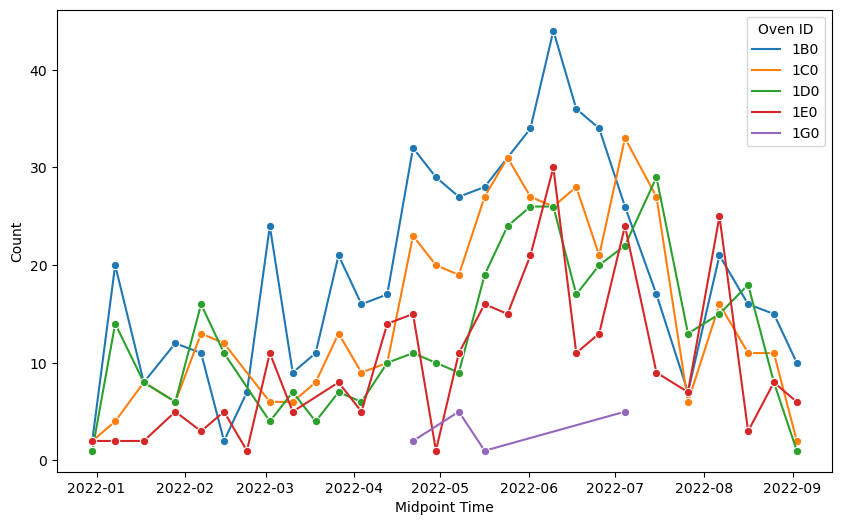

In [44]:
oven1_data['start'] = pd.to_datetime(oven1_data['start'], format='%y/%m/%d', yearfirst=True)
oven1_data['end'] = pd.to_datetime(oven1_data['end'], format='%y/%m/%d', yearfirst=True)

oven1_data['midpoint'] = oven1_data['start'] + (oven1_data['end'] - oven1_data['start']) / 2
sum_count_by_group = oven1_data.groupby(['start', 'end', 'oven_id'])[['count']].sum().reset_index()
sum_count_by_group['midpoint'] = sum_count_by_group['start'] + (sum_count_by_group['end'] - sum_count_by_group['start']) / 2

plt.figure(figsize=(10, 6))
sns.lineplot(data=sum_count_by_group, x='midpoint', y='count', hue='oven_id', marker='o', errorbar=None)
plt.xlabel('Midpoint Time')
plt.ylabel('Count')
plt.legend(title='Oven ID')
plt.show()

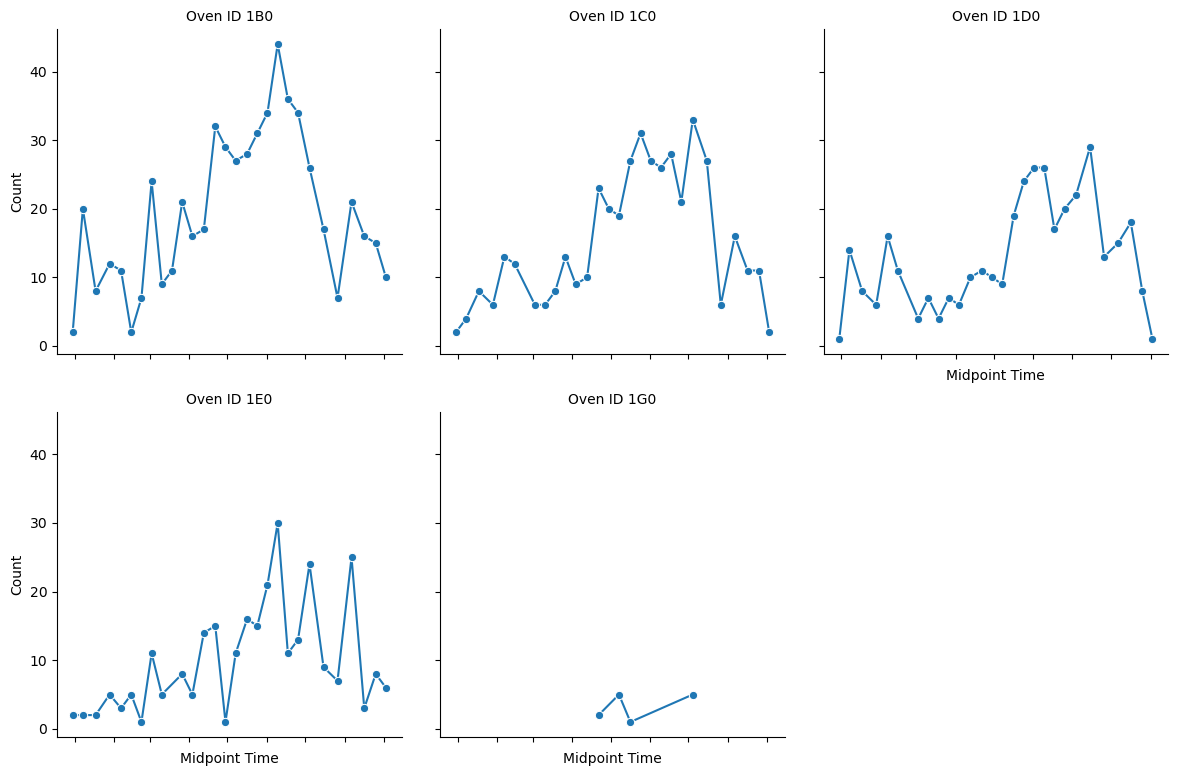

In [45]:
g = sns.FacetGrid(sum_count_by_group, col='oven_id', col_wrap=3, height=4)
g.map(sns.lineplot, 'midpoint', 'count', marker='o', errorbar=None)
g.set_axis_labels('Midpoint Time', 'Count')
g.set_titles('Oven ID {col_name}')
g.set_xticklabels(rotation=45)
#plt.tight_layout()
plt.show()

/tmp/ipykernel_32/589308418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oven2_data['start'] = pd.to_datetime(oven2_data['start'], format='%y/%m/%d', yearfirst=True)
/tmp/ipykernel_32/589308418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oven2_data['end'] = pd.to_datetime(oven2_data['end'], format='%y/%m/%d', yearfirst=True)
/tmp/ipykernel_32/589308418.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

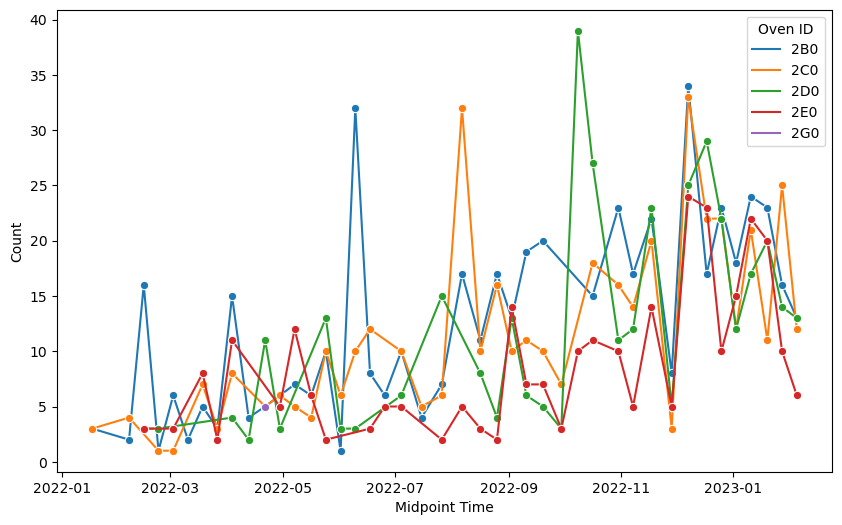

In [46]:
oven2_data['start'] = pd.to_datetime(oven2_data['start'], format='%y/%m/%d', yearfirst=True)
oven2_data['end'] = pd.to_datetime(oven2_data['end'], format='%y/%m/%d', yearfirst=True)

oven2_data['midpoint'] = oven2_data['start'] + (oven2_data['end'] - oven2_data['start']) / 2
sum_count_by_group = oven2_data.groupby(['start', 'end', 'oven_id'])[['count']].sum().reset_index()
sum_count_by_group['midpoint'] = sum_count_by_group['start'] + (sum_count_by_group['end'] - sum_count_by_group['start']) / 2

plt.figure(figsize=(10, 6))
sns.lineplot(data=sum_count_by_group, x='midpoint', y='count', hue='oven_id', marker='o', errorbar=None)
plt.xlabel('Midpoint Time')
plt.ylabel('Count')
plt.legend(title='Oven ID')
plt.show()

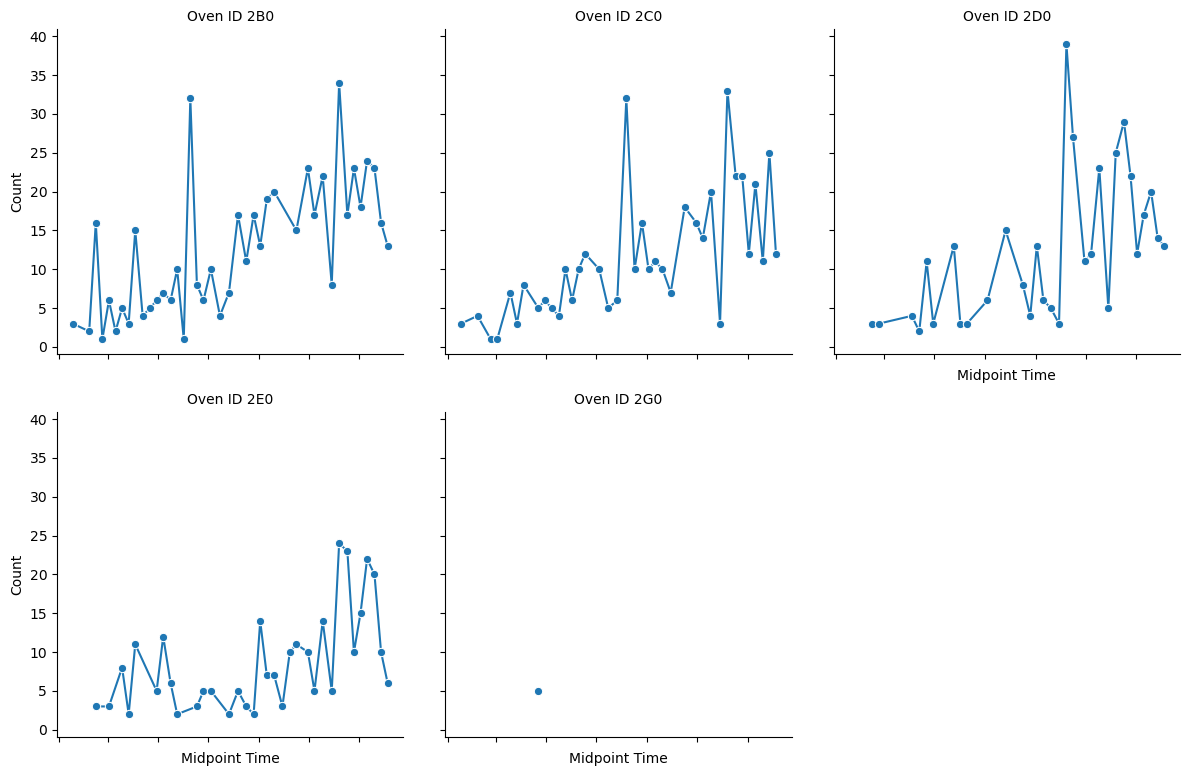

In [47]:
g = sns.FacetGrid(sum_count_by_group, col='oven_id', col_wrap=3, height=4)
g.map(sns.lineplot, 'midpoint', 'count', marker='o', errorbar=None)
g.set_axis_labels('Midpoint Time', 'Count')
g.set_titles('Oven ID {col_name}')
g.set_xticklabels(rotation=45)
#plt.tight_layout()
plt.show()

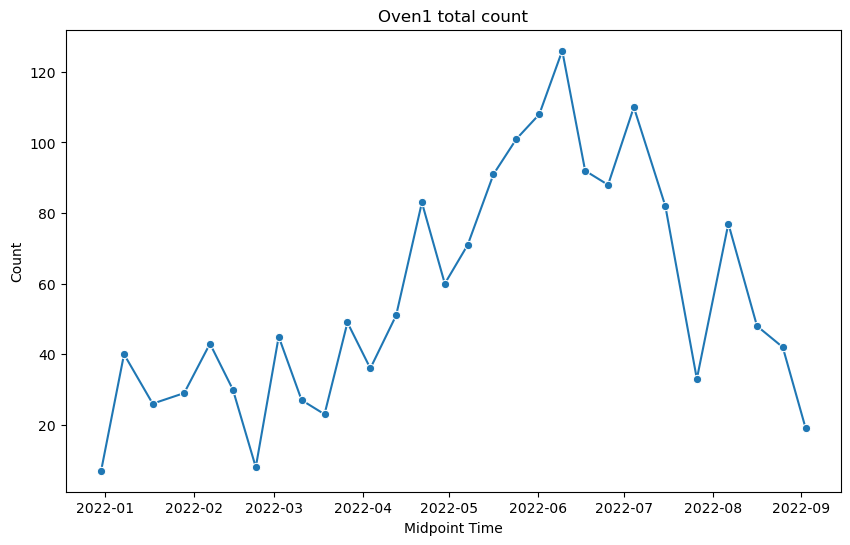

In [48]:
sum_count_by_group = oven1_data.groupby(['start', 'end'])[['count']].sum().reset_index()
sum_count_by_group['midpoint'] = sum_count_by_group['start'] + (sum_count_by_group['end'] - sum_count_by_group['start']) / 2

plt.figure(figsize=(10, 6))
sns.lineplot(data=sum_count_by_group, x='midpoint', y='count', marker='o', errorbar=None)
plt.xlabel('Midpoint Time')
plt.ylabel('Count')
plt.title('Oven1 total count')
plt.show()

ARMA

In [14]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# #count_series = pd.Series(count_series, index=sum_count_by_group['midpoint'])

# train = count_series[:25]
# test = count_series[25:]

# model = SARIMAX(train, order=(3, 0, 3), seasonal_order=(0,0,0,4))
# result = model.fit()
# y_pred = result.fittedvalues
# y_pred_test = result.predict(start=len(train), end=len(train) + len(test)-1 )

# train_mse = mean_squared_error(train, y_pred)
# train_r2 = r2_score(train, y_pred)
# print("Mean Squared Error:", train_mse)
# print("R-squared:", train_r2)

# plt.figure(figsize=(12, 6))
# plt.plot(train, label='actual')
# plt.plot(y_pred, label='pred')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Count')
# plt.title('SARMA(3,2)')
# plt.show()

# test_mse = mean_squared_error(test, y_pred_test)
# test_r2 = r2_score(test, y_pred_test)
# print("Mean Squared Error on Test:", test_mse)
# print("R-squared on Test:", test_r2)

# plt.figure(figsize=(12, 6))
# plt.plot(test, label='Actual')
# plt.plot(y_pred_test, label='Predicted')
# plt.legend()
# plt.xlabel('Time')
# plt.ylabel('Count')
# plt.title('ARMA(1,1) on Test Data')
# plt.show()

In [15]:
# sum_count_by_ovengroup = oven1_data.groupby(['start', 'end', 'oven_id']).agg({'accumulation_hour': 'mean',
#                                                                               'water_volume_lower': 'mean',
#                                                                               'water_volume_upper': 'mean',
#                                                                               'in_temp': 'mean',
#                                                                               'out_temp': 'mean',
#                                                                               'a_temp': 'mean',
#                                                                               'b_temp': 'mean',
#                                                                               'count': 'sum',
#                                                                               'total_count': 'sum'
#                                                                               }).reset_index()
# sum_count_by_ovengroup_1B0 = sum_count_by_ovengroup[sum_count_by_ovengroup['oven_id'] == '1B0']
# sum_count_by_ovengroup_1B0['start'] = pd.to_datetime(sum_count_by_ovengroup_1B0['start']).apply(lambda x: x.replace(hour=0, minute=0, second=0))

# sum_count_by_ovengroup_1B0.loc[:,'start'] = sum_count_by_ovengroup_1B0['start'].dt.strftime('%Y-%m-%d %H:%M:%S')
# sum_count_by_ovengroup_1B0.reset_index()

In [16]:
# time_points = [
# '2021-12-27 00:00:00', '2022-01-04 00:00:00', '2022-01-14 00:00:00', '2022-01-25 00:00:00', '2022-02-03 00:00:00',
# '2022-02-11 00:00:00', '2022-02-19 00:00:00', '2022-02-27 00:00:00', '2022-03-07 00:00:00', '2022-03-15 00:00:00',
# '2022-03-23 00:00:00', '2022-03-31 00:00:00', '2022-04-09 00:00:00', '2022-04-18 00:00:00', '2022-04-26 00:00:00',
# '2022-05-04 00:00:00', '2022-05-13 00:00:00', '2022-05-21 00:00:00', '2022-05-29 00:00:00', '2022-06-06 00:00:00',
# '2022-06-14 00:00:00', '2022-06-22 00:00:00', '2022-07-01 00:00:00', '2022-07-12 00:00:00', '2022-07-23 00:00:00',
# '2022-08-03 00:00:00', '2022-08-13 00:00:00', '2022-08-22 00:00:00', '2022-08-30 00:00:00'
# ]
# time = sum_count_by_ovengroup_1B0['start'].astype(str).values
# for time_point in time_points:
#     if time_point not in time:
#         new_row = {
#             'index': None,
#             'start': time_point,
#             'end': None,
#             'oven_id': None,
#             'accumulation_hour': 0,
#             'water_volume_lower': 0,
#             'water_volume_upper': 0,
#             'in_temp': 0,
#             'out_temp': 0,
#             'a_temp': 0,
#             'b_temp': 0,
#             'count': 0,
#             'total_count':0
#         }
#         sum_count_by_ovengroup_1B0 = sum_count_by_ovengroup_1B0.append(new_row, ignore_index=True)
# sum_count_by_ovengroup_1B0 = sum_count_by_ovengroup_1B0.sort_values(by='start')
# sum_count_by_ovengroup_1B0

In [17]:
# count_series_byoven = sum_count_by_ovengroup_1B0['count']

<font size="5">以下為用滑動窗口交叉驗證方法找到最好的參數組合，與對資料做一些整理。

In [50]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def find_best_parameters(train_data, test_data, order_range, seasonal_order_range):
    best_r2 = -float('inf')
    best_order = None
    best_seasonal_order = None

    n_splits = 10
    if len(train_data) < 26:
        window_length = 19
    else:
        window_length = 35
    step_length = 1
    cv = SlidingWindowSplitter(window_length=window_length, fh=[1, 2, 3, 4], step_length=step_length, start_with_window=True)
    
    for order in order_range:
        for seasonal_order in seasonal_order_range:
            r2_scores = []
            for train_window, test_window in cv.split(train_data):
                train_data_window = train_data.iloc[train_window]
                test_data_window = train_data.iloc[test_window]
                model = SARIMAX(train_data_window, order=order, seasonal_order=seasonal_order)
                result = model.fit(disp=False)
                y_pred_test = result.forecast(steps=len(test_data_window))
                r2 = r2_score(test_data_window, y_pred_test)
                r2_scores.append(r2)
            
            mean_r2 = np.mean(r2_scores)
            
            if mean_r2 > best_r2:
                best_r2 = mean_r2
                best_order = order
                best_seasonal_order = seasonal_order
    
    final_model = SARIMAX(train_data, order=best_order, seasonal_order=best_seasonal_order)
    result = final_model.fit(disp=False)
    final_pred_train = result.fittedvalues
    final_pred_test = result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    final_pred_sum = sum(final_pred_test)
    target = result.predict(start=len(train_data) + len(test_data), end=len(train_data) + len(test_data) + 3)
    
    return best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target

In [19]:
# window_length = 17
# step_length = 1
# cv = SlidingWindowSplitter(window_length=window_length, fh=[1, 2, 3, 4], step_length=step_length, start_with_window=True)
# for train_window, test_window in cv.split(train_data):
#     train_data_window = train_data.iloc[train_window]
#     test_data_window = train_data.iloc[test_window]
#     print(train_data_window)

In [51]:
def data_preparation(oven_data, oven_id, N):
    sum_count_by_ovengroup = oven_data.groupby(['start', 'end', 'oven_id']).agg({'accumulation_hour': 'mean',
                                                                              'water_volume_lower': 'mean',
                                                                              'water_volume_upper': 'mean',
                                                                              'in_temp': 'mean',
                                                                              'out_temp': 'mean',
                                                                              'a_temp': 'mean',
                                                                              'b_temp': 'mean',
                                                                              'count': 'sum',
                                                                              'total_count': 'sum'
                                                                              }).reset_index()
    sum_count_by_ovengroup = sum_count_by_ovengroup[sum_count_by_ovengroup['oven_id'] == oven_id]
    sum_count_by_ovengroup['start'] = pd.to_datetime(sum_count_by_ovengroup['start']).apply(lambda x: x.replace(hour=0, minute=0, second=0))
    sum_count_by_ovengroup.loc[:,'start'] = sum_count_by_ovengroup['start'].dt.strftime('%Y-%m-%d %H:%M:%S')
    sum_count_by_ovengroup.reset_index()
    
    if oven_id.startswith('1'):
        time_points = [
        '2021-12-27 00:00:00', '2022-01-04 00:00:00', '2022-01-14 00:00:00', '2022-01-25 00:00:00', '2022-02-03 00:00:00',
        '2022-02-11 00:00:00', '2022-02-19 00:00:00', '2022-02-27 00:00:00', '2022-03-07 00:00:00', '2022-03-15 00:00:00',
        '2022-03-23 00:00:00', '2022-03-31 00:00:00', '2022-04-09 00:00:00', '2022-04-18 00:00:00', '2022-04-26 00:00:00',
        '2022-05-04 00:00:00', '2022-05-13 00:00:00', '2022-05-21 00:00:00', '2022-05-29 00:00:00', '2022-06-06 00:00:00',
        '2022-06-14 00:00:00', '2022-06-22 00:00:00', '2022-07-01 00:00:00', '2022-07-12 00:00:00', '2022-07-23 00:00:00',
        '2022-08-03 00:00:00', '2022-08-13 00:00:00', '2022-08-22 00:00:00', '2022-08-30 00:00:00'
        ]
    elif oven_id.startswith('2'):
        time_points = [
        '2022-01-14 00:00:00', '2022-01-23 00:00:00', '2022-02-03 00:00:00', '2022-02-11 00:00:00', '2022-02-19 00:00:00',
        '2022-02-27 00:00:00', '2022-03-07 00:00:00', '2022-03-15 00:00:00', '2022-03-23 00:00:00', '2022-03-31 00:00:00',
        '2022-04-09 00:00:00', '2022-04-18 00:00:00', '2022-04-26 00:00:00', '2022-05-04 00:00:00', '2022-05-13 00:00:00',
        '2022-05-21 00:00:00', '2022-05-29 00:00:00', '2022-06-06 00:00:00', '2022-06-14 00:00:00', '2022-06-22 00:00:00',
        '2022-07-01 00:00:00', '2022-07-12 00:00:00', '2022-07-23 00:00:00', '2022-08-03 00:00:00', '2022-08-13 00:00:00',
        '2022-08-22 00:00:00', '2022-08-30 00:00:00', '2022-09-07 00:00:00', '2022-09-16 00:00:00', '2022-09-26 00:00:00',
        '2022-10-05 00:00:00', '2022-10-13 00:00:00', '2022-10-27 00:00:00', '2022-11-04 00:00:00', '2022-11-14 00:00:00',
        '2022-11-25 00:00:00', '2022-12-04 00:00:00', '2022-12-14 00:00:00', '2022-12-22 00:00:00', '2022-12-30 00:00:00',
        '2023-01-07 00:00:00', '2023-01-16 00:00:00', '2023-01-24 00:00:00', '2023-02-01 00:00:00'
        ]

    time = sum_count_by_ovengroup['start'].astype(str).values
    for time_point in time_points:
        if time_point not in time:
            new_row = {
                'index': None,
                'start': time_point,
                'end': None,
                'oven_id': None,
                'accumulation_hour': 0,
                'water_volume_lower': 0,
                'water_volume_upper': 0,
                'in_temp': 0,
                'out_temp': 0,
                'a_temp': 0,
                'b_temp': 0,
                'count': 0,
                'total_count': 0
            }
            sum_count_by_ovengroup = sum_count_by_ovengroup.append(new_row, ignore_index=True)
    sum_count_by_ovengroup = sum_count_by_ovengroup.sort_values(by='start')
    count_series_byoven = sum_count_by_ovengroup['total_count']
    new_index = range(len(count_series_byoven))
    reindexed_series = pd.Series([count_series_byoven.iloc[i] for i in new_index], index=new_index)
    train_data = reindexed_series[:N]
    test_data = reindexed_series[N:]
    return train_data, test_data, sum_count_by_ovengroup

In [52]:
def plot_out(train_data, final_pred_train, test_data, final_pred_test):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label='actual')
    plt.plot(final_pred_train, label='pred')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.title(f'SARMA{best_order}{best_seasonal_order}')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(test_data, label='actual')
    plt.plot(final_pred_test, label='pred')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.title(f'SARMA{best_order}{best_seasonal_order}')
    plt.show()

In [53]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [54]:
order_range = [(p, d, q) for p in range(5) for d in range(2) for q in range(5)]
seasonal_order_range = [(0, 0, 0, p) for p in range(2,5)]

In [55]:
train_data, test_data, sum_count_by_ovengroup = data_preparation(oven1_data, '1B0', 25)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (1, 0, 4)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
25    13.776983
26    13.499199
27     6.103858
28    -2.054881
Name: predicted_mean, dtype: float64
y_actual_test
25    22
26    16
27    15
28    11
dtype: int64
Final Prediction: 31.32515893217241
Actual Value: 64
RMSE: 8.992264315785963
Target: -6.348855854112182


In [56]:
train_data, test_data, sum_count_by_ovengroup= data_preparation(oven1_data, '1C0', 25)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (2, 1, 2)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
25    18.804862
26    21.831303
27     9.880919
28    19.060115
Name: predicted_mean, dtype: float64
y_actual_test
25    17
26    11
27    11
28     2
dtype: int64
Final Prediction: 69.57719939484753
Actual Value: 41
RMSE: 10.159656743067163
Target: 68.19978204569354


In [57]:
train_data, test_data, sum_count_by_ovengroup= data_preparation(oven1_data, '1D0', 25)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (0, 1, 2)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
25    16.724914
26    19.304927
27    19.304927
28    19.304927
Name: predicted_mean, dtype: float64
y_actual_test
25    16
26    21
27     9
28     1
dtype: int64
Final Prediction: 74.63969506067562
Actual Value: 47
RMSE: 10.543489134675594
Target: 77.2197085425001


In [58]:
train_data, test_data, sum_count_by_ovengroup= data_preparation(oven1_data, '1E0', 25)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (3, 0, 0)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
25    16.839974
26    11.217916
27     7.725283
28    12.308510
Name: predicted_mean, dtype: float64
y_actual_test
25    25
26     3
27     8
28     6
dtype: int64
Final Prediction: 48.09168314714482
Actual Value: 42
RMSE: 6.59531886285474
Target: 38.45440608866897


In [59]:
train_data, test_data, sum_count_by_ovengroup= data_preparation(oven2_data, '2B0', 40)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (3, 1, 0)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
40    26.021491
41    20.778853
42    24.047856
43    21.367714
Name: predicted_mean, dtype: float64
y_actual_test
40    27
41    23
42    16
43    14
dtype: int64
Final Prediction: 92.21591338760163
Actual Value: 80
RMSE: 5.5888765387491475
Target: 91.03253903408836


In [60]:
train_data, test_data, sum_count_by_ovengroup= data_preparation(oven2_data, '2C0', 40)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (4, 1, 0)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
40    13.892064
41    20.972677
42    18.149588
43    19.940851
Name: predicted_mean, dtype: float64
y_actual_test
40    22
41    12
42    27
43    12
dtype: int64
Final Prediction: 72.95517924866442
Actual Value: 73
RMSE: 8.479894715906992
Target: 69.9823682180229


In [61]:
train_data, test_data, sum_count_by_ovengroup= data_preparation(oven2_data, '2D0', 40)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (0, 1, 4)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
40    16.036953
41    16.565589
42    15.731853
43    14.897092
Name: predicted_mean, dtype: float64
y_actual_test
40    17
41    21
42    16
43    13
dtype: int64
Final Prediction: 63.231488419999515
Actual Value: 67
RMSE: 2.462839660484779
Target: 59.588368361262354


In [62]:
train_data, test_data, sum_count_by_ovengroup= data_preparation(oven2_data, '2E0', 40)
best_order, best_seasonal_order, best_r2, final_pred_sum, final_pred_test, final_pred_train, target = find_best_parameters(train_data, test_data, order_range, seasonal_order_range)
#plot_out(train_data, final_pred_train, test_data, final_pred_test)

print("Best Order:", best_order)
print("Best Seasonal Order:", best_seasonal_order)
#print("Best R-squared:", best_r2)
print("y_pred_test:\n", final_pred_test,sep="")
print("y_actual_test\n", test_data,sep="")
print("Final Prediction:", final_pred_sum)
print("Actual Value:", sum(test_data))
print("RMSE:",rmse(test_data, final_pred_test))
print("Target:",sum(target))

Best Order: (1, 1, 0)
Best Seasonal Order: (0, 0, 0, 2)
y_pred_test:
40    13.238544
41    14.509484
42    13.924543
43    14.193758
Name: predicted_mean, dtype: float64
y_actual_test
40    23
41    21
42    12
43     6
dtype: int64
Final Prediction: 55.866328808432215
Actual Value: 62
RMSE: 7.215510308522992
Target: 56.410080615595426


<font size="5">因此我們有了8個爐對應的預測值並做成表格，這裡的預測值為資料的最後一個月份的燈泡壞掉數量

In [33]:
#result(use best train set to predict)
my_predict = {'Lines': ['1B0', '1C0', '1D0', '1E0', '2B0', '2C0', '2D0', '2E0'],
              'prediction_anomaly_total_number': [31.325, 69.577, 74.640, 48.091, 92.216, 72.955, 63.231, 55.866],
              'actual_anomaly_total_number' : [64, 41, 47, 42, 80, 73, 67, 62],
              'absoluted error': [32.675, 28.577, 27.64, 6.091, 12.216, 0.045, 3.769, 6.134],
              'RMSE' : [8.992, 10.160, 10.543, 6.595, 5.589, 8.480, 2.463, 7.216],
              'Target' : [-6.349, 68.200, 77.220, 38.454, 91.033, 69.982, 59.588, 56.410]
              }
my_predict = pd.DataFrame(my_predict)
my_predict.set_index('Lines' , inplace=True)
my_predict

,prediction_anomaly_total_number,actual_anomaly_total_number,absoluted error,RMSE,Target
Lines,,,,,
1B0,31.325,64,32.675,8.992,-6.349
1C0,69.577,41,28.577,10.160,68.200
1D0,74.640,47,27.640,10.543,77.220
1E0,48.091,42,6.091,6.595,38.454
2B0,92.216,80,12.216,5.589,91.033
2C0,72.955,73,0.045,8.480,69.982
2D0,63.231,67,3.769,2.463,59.588
2E0,55.866,62,6.134,7.216,56.410


<font size="5">結論，經過討論我們認為這筆燈泡快掉數量的資料不適合用時間序列分析，首先，資料的完整性有嚴重的瑕疵會導致時間序列分析的結果不和預期，第二，單存從時間序列分析的角度來分析或許存在問題，可以從加入外生變數的方法來預測數量，例如加入accumulation_hour這個變數進來可能會有更好的結果，但是因為時間關係加上這項比賽需要我們預測往後的月份燈泡壞掉數量，但是我們無法取得往後月份的accumulation_hour，這樣會使得模型無法進行預測，所以我們果斷放棄這個方法並單純只從時間的角度進行分析。